In [1]:
import pandas as pd
from pandasql import sqldf
import boto3
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
from geopy.distance import distance
import numpy as np
from sklearn.preprocessing import Normalizer
from keras import models, layers
from sklearn.model_selection import train_test_split
%run '../extra_fns.ipynb'
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


In [2]:
with open('../config.json') as json_data:
    config = json.load(json_data)

In [3]:
s3 = boto3.client(
    's3',
    aws_access_key_id=config['boto']['aws_access_key_id'],
    aws_secret_access_key=config['boto']['aws_secret_access_key']
)

In [4]:
model_dir = 'trained_models'
try:
    os.makedirs(model_dir)
except Exception as e:
    print(e)

[Errno 17] File exists: 'trained_models'


In [5]:
data_dir = 'data'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# train_file = data_dir + '/train.csv'
# test_file = data_dir + '/test.csv'

# s3.upload_file(src_file, boto_config['buckets']['kaggle'], src_file)
# s3.upload_file(src_file_cleaned, boto_config['buckets']['kaggle'], src_file_cleaned)

# s3.download_file(boto_config['buckets']['kaggle'], src_file, src_file)
# s3.download_file(boto_config['buckets']['kaggle'], src_file_cleaned, src_file_cleaned)

# train = pd.read_csv(train_file)
# test = pd.read_csv(test_file)

In [6]:
# train['distance'] = train.apply(lambda row : int(distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])).m), axis=1)

# train.pickup_datetime = pd.to_datetime(train.pickup_datetime)

# train['pickup_monthday'] = train.pickup_datetime.dt.day
# train['pickup_weekday'] = train.pickup_datetime.dt.weekday
# train['pickup_hour'] = train.pickup_datetime.dt.hour

In [7]:
# test['distance'] = test.apply(lambda row : int(distance(
#     (row['pickup_latitude'], row['pickup_longitude']),
#     (row['dropoff_latitude'], row['dropoff_longitude'])).m), axis=1)

# test.pickup_datetime = pd.to_datetime(test.pickup_datetime)

# test['pickup_monthday'] = test.pickup_datetime.dt.day
# test['pickup_weekday'] = test.pickup_datetime.dt.weekday
# test['pickup_hour'] = test.pickup_datetime.dt.hour

In [13]:
# train.to_csv('./data/train-clean.csv')
# test.to_csv('./data/test-clean.csv')

train = pd.read_csv('./data/train-clean.csv')
test = pd.read_csv('./data/test-clean.csv')

# Clean data

In [14]:
train = train[(train.trip_duration<3600) & (train.distance<30000) & (train.trip_duration>180)]

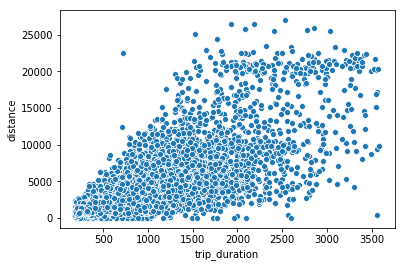

In [15]:
sns.scatterplot(x='trip_duration', y='distance', data=train.sample(10000))
plt.show()

In [16]:
train['avg_speed'] = (train.distance*3600)/(train.trip_duration*1000)

In [17]:
train = train[(train.avg_speed<70) & (train.avg_speed>8)]

# NN

In [18]:
callbacks = [
    EarlyStopping(monitor='val_mean_absolute_error', patience=1),
    ModelCheckpoint(filepath=model_dir + '/basic_model.h5', monitor='val_loss', save_best_only=True)
]

In [19]:
y_train = np.array(train.trip_duration)
X_train = np.array(train.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_test = np.array(test.loc[:, ['passenger_count', 'distance', 'pickup_monthday', 'pickup_weekday', 'pickup_hour', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']])

In [20]:
nml = Normalizer()

X_train = nml.fit_transform(X_train)
X_val = nml.transform(X_val)
X_test = nml.transform(X_test)

In [21]:
nn = models.Sequential()
nn.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
nn.add(layers.Dense(32, activation='relu'))
nn.add(layers.Dropout(0.2))
nn.add(layers.Dense(16, activation='relu'))
nn.add(layers.Dropout(0.2))
nn.add(layers.Dense(1))

nn.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])

nn.summary()

history = nn.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=512,
                    callbacks=callbacks,
                    validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________
Train on

Min Val Absolute Error 205.8628289435491 on Epoch 4


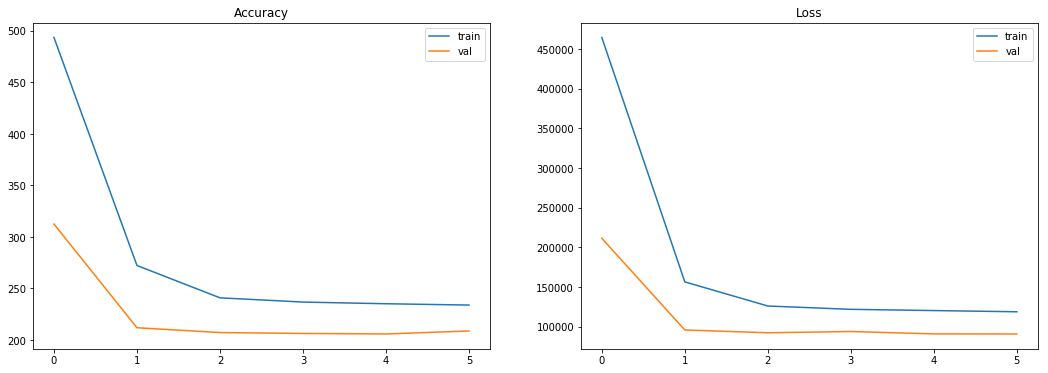

In [22]:
results = history.history
epochs = history.epoch

print('Min Val Absolute Error {0} on Epoch {1}'.format(np.min(results['val_mean_absolute_error']), np.argmin(results['val_mean_absolute_error'])))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))

ax1.plot(epochs, results['mean_absolute_error'], label='train')
ax1.plot(epochs, results['val_mean_absolute_error'], label='val')
ax1.set_title('Accuracy')
# ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(epochs, results['loss'], label='train')
ax2.plot(epochs, results['val_loss'], label='val')
ax2.set_title('Loss')
ax2.legend()

plt.show()

# XGBoost

In [23]:
xg = xgboost.XGBRegressor(nthread=-1)

In [24]:
xg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=-1, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
xg_predictions = xg.predict(X_val)

In [26]:
mae(y_val, xg_predictions)

193.48376377116722

# Ensemble Predictions

In [27]:
nn_predictions = nn.predict(X_test)
xg_predictions = xg.predict(X_test)
xg_predictions = xg_predictions.reshape((nn_predictions.shape[0],1))

In [28]:
predictions = nn_predictions*0.5+xg_predictions*0.5

In [29]:
subs = pd.DataFrame()
subs['id'] = test.id
subs['trip_duration'] = predictions

subs.to_csv(data_dir + '/subs.csv', index=False)